![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FWorking+With%2FDocument+AI&file=Document+AI+Processors+-+Invoice+Parser.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Working%20With/Document%20AI/Document%20AI%20Processors%20-%20Invoice%20Parser.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A//raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Working%20With/Document%20AI/Document%20AI%20Processors%20-%20Invoice%20Parser.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Working%20With/Document%20AI/Document%20AI%20Processors%20-%20Invoice%20Parser.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https%3A//raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Working%20With/Document%20AI/Document%20AI%20Processors%20-%20Invoice%20Parser.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# Document AI Processors - Invoice Parser
> From the [Working With Document AI](https://github.com/statmike/vertex-ai-mlops/blob/main/Working%20With/Document%20AI/readme.md) series in the [vertex-ai-mlops](https://github.com/statmike/vertex-ai-mlops/blob/main/readme.md) repository.

Document AI is an API where you interact with processors to extract information from documents.  You enable the API, create an instance of a processor in your project, send in document(s), receive back JSON with the extracted information:

<p align="center" width="100%"><center>
    <img src="../../architectures/architectures/images/working with/documentai/readme/high_level.png">
</center></p>

This notebook uses the specialized [Invoice parser](https://cloud.google.com/document-ai/docs/processors-list#processor_invoice-processor) which, in addition to OCR, also detects invoice specific [entities](https://cloud.google.com/document-ai/docs/processors-list#expandable-72).  This parser can even be customized with [uptraining](https://cloud.google.com/document-ai/docs/workbench/uptrain-processor). 

---

**Processing**

A prior workflow covered all the ways to process a document, or many documents, using Python as the client: [Document AI - Process Documents](./Document%20AI%20-%20Process%20Documents.ipynb). It also shows how to store and retrieve responses from GCS and BigQuery.

---

**Responses**

There are many ways to process the responses from Document AI to extract the parts needed for a downstream applicaiton: paragraphs, tokens, entities, tables, much more!  The choice will depend on the application workflow and if a single document is being processed, a batch of documents, or an entire history of documents is being processed.  A prior workflow covered three common ways to process responses:
[Document AI - Process Responses](./Document%20AI%20-%20Process%20Responses.ipynb)
- Extraction: Python With Document AI Client
- Extraction: Python With Document AI Toolbox
- Extraction: Directly In BigQuery With SQL

---

**References:**
- [Python Client For Document AI](https://cloud.google.com/python/docs/reference/documentai/latest)
    - [documentai.Document()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document)
- [Document AI Overview](https://cloud.google.com/document-ai/docs/overview)
    - [Handling the processing response](https://cloud.google.com/document-ai/docs/handle-response)

---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Working%20With/Document%20AI/Document%20AI%20Processors%20-%20Invoice%20Parser.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs and API Enablement

The clients packages may need installing in this environment. 

### Installs (If Needed)

In [3]:
# tuples of (import name, install name)
packages = [
    ('google.cloud.documentai', 'google-cloud-documentai'),
    ('PIL', 'Pillow'),
    ('PyPDF2', 'PyPDF2')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user

### API Enablement

In [4]:
!gcloud services enable documentai.googleapis.com

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [5]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

---
## Setup

Inputs

In [6]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [7]:
REGION = 'us-central1'
SERIES = 'working-with-docai'
EXPERIMENT = 'invoice-parser'

Packages

In [9]:
import os, io, json

import PyPDF2
import IPython
import PIL, PIL.ImageFont, PIL.Image, PIL.ImageDraw

from google.cloud import documentai

Clients

In [10]:
# document AI client
LOCATION = REGION.split('-')[0]
docai = documentai.DocumentProcessorServiceClient(
    client_options = dict(api_endpoint = f"{LOCATION}-documentai.googleapis.com")
)

---
## Get The Document

This section prepares a document for processing with online processing.

`../shared files/docs/bill.pdf`

If you are working from a clone of this notebooks repository then the document is already present. The following cell checks for the documents folder, `../shared_files/docs`, and if it is missing gets the document used in this workflow (`wget`):

In [11]:
file = '../shared files/docs/bill.pdf'

if not os.path.exists(file):
    print('Retrieving document...')
    if not os.path.exists(os.path.dirname(file)):
      os.makedirs(os.path.dirname(file))
    import requests, urllib.parse
    r = requests.get(f'https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Working%20With/{urllib.parse.quote(file[3:])}')
    open(file, 'wb').write(r.content)
    print(f'Document now at `{file}`')
else:
    print(f'Document Found at `{file}`')

Document Found at `../shared files/docs/bill.pdf`


---
## Create/Get A Processor

For this workflow we will use the [Invoice parser](https://cloud.google.com/document-ai/docs/processors-list#processor_invoice-processor). We can check for an existing processor in the project and if it is not present then create one.  The processor will be connected with Python variable `PARSER` and referred to as a parser as it is used.

Get the type and version from the list of available processors: https://cloud.google.com/document-ai/docs/processors-list

What are the processors already created in this project environment?

In [12]:
processors = list(docai.list_processors(parent = f'projects/{PROJECT_ID}/locations/{LOCATION}'))
len(processors)

6

In [13]:
TYPE = 'INVOICE_PROCESSOR'
VERSION = 'pretrained-invoice-v1.5-2023-09-15'

Get an existing processor:

In [14]:
PARSER = ''
for processor in processors:
    if processor.type_ == TYPE and processor.default_processor_version.split('/')[-1] == VERSION:
        PARSER = processor
        break
        
if PARSER:
    print(f'There is an existing processor with the desire type and version in PARSER = {PARSER.display_name}')
else:
    print(f'Need to create a processor for the desired type and version: {TYPE}, {VERSION}')

Need to create a processor for the desired type and version: INVOICE_PROCESSOR, pretrained-invoice-v1.5-2023-09-15


Create the processor if an existing one was not found to match:

In [15]:
if not PARSER:
    PARSER = docai.create_processor(
        parent = f'projects/{PROJECT_ID}/locations/{LOCATION}',
        processor = documentai.Processor(
            display_name = f'{SERIES}-{EXPERIMENT}',
            type_ = TYPE
        )
    )
    set_default = docai.set_default_processor_version(
        request = documentai.SetDefaultProcessorVersionRequest(
            processor = PARSER.name,
            default_processor_version = f'{PARSER.name}/processorVersions/{VERSION}'
        )
    )
    set_default.result()
    PARSER = docai.get_processor(
        name = PARSER.name
    )
    print(f'Processor created and in PARSER variable with display name = {PARSER.display_name}')

Processor created and in PARSER variable with display name = working-with-docai-invoice-parser


---
## Online Processing (single document)

> A prior workflow covered all the ways to process a document, or many documents, using Python as the client: [Document AI - Process Documents](./Document%20AI%20-%20Process%20Documents.ipynb). It also shows how to store and retrieve responses from GCS and BigQuery.

This section uses one of the three online processing methods: `inline_document` where the document is provided as a bytes object.

> NOTE: The [Summarizer Processor](https://cloud.google.com/document-ai/docs/processors-list#processor_SUMMARIZER) has a page limits of 15 for online, and 250 for batch processing.

The following is the Python client reference to use for this online processing section:
- [google.cloud.documentai.DocumentProcessorServiceClient.process_document()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.services.document_processor_service.DocumentProcessorServiceClient#google_cloud_documentai_v1_services_document_processor_service_DocumentProcessorServiceClient_process_document)

Using the processor stored in `PARSER` from above:

In [16]:
PARSER.name

'projects/1026793852137/locations/us/processors/704ff47a8e5377a2'

Read the document to a bytes object:

In [17]:
with open(file, 'rb') as f:
    local_doc = f.read()

In [18]:
type(local_doc)

bytes

---
### Document as bytes: `inline_document`

Reference:
- [documentai.ProcessRequest()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessRequest)
    - (This One) `inline_document` = [documentai.Document()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document)
    - `raw_document` = [documentai.RawDocument()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.RawDocument)
    - `gcs_document` = [documentai.GcsDocument()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.GcsDocument)

In [19]:
response = docai.process_document(
    request = documentai.ProcessRequest(
        name = PARSER.name,
        inline_document = documentai.Document(
            content = local_doc,
            mime_type = 'application/pdf'
        ),
        process_options = documentai.ProcessOptions(
            from_start = 3
        )
    )
)

In [20]:
len(response.document.pages)

1

In [21]:
print(response.document.text[0:250])

M
ATLANTA MARRIOTT MIDTOWN STES
GUEST FOLIO
MARRIOTT
420
191.20
11/17/23
08:02
37451
ROOM
RATE
DEPART
TIME
ACCT#
NSKG
11/16/23
18:25
TYPE
ARRIVE
TIME
15
PASSPORT:
VSXXXXXXXXXXXX1444
ROOM
MBV#:
XXXXX1107
ADDRESS
CLERK
PAYMENT
DATE
REFERENCES
CHARGES
C


---
## Extraction Methods

Below, the Python Client for Document AI is used to extract the parts of the OCR response.  There are other methods that could be better for different application flows.  The workflow [Document AI - Process Responses](./Document%20AI%20-%20Process%20Responses.ipynb) covers additional methods.
- Extraction: Python With Document AI Client
- Extraction: Python With Document AI Toolbox
- Extraction: Directly In BigQuery With SQL

---
## Extraction: Python With Document AI Client

The response from online processing is a [`documentai.ProcessResponse()`](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessResponse) which has a `document` attribute that is a [`documentai.Document()`](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document) protobuf.  This object can be directly used to extract elements of the document.  It can also be converted to other data types that can be iterated in Python:
- JSON with `response.document.to_json()`
- Dictionary with `response.document.to_dict()`
- > Note: These follow the `google.protobuf.json_format` - [reference](https://googleapis.dev/python/protobuf/latest/google/protobuf/json_format.html).  That means the parameters of `.to_dict()` are the same as `google.protobuf.json_format.MessageToDict()` which includes `use_integer_for_enums` which should be set `= False` to get the text representation of enum values.

The workflow has a helpful guide to the structure of the `documentai.Document` object in the [readme.md](./readme.md).

In [22]:
response.document.mime_type

'application/pdf'

### OCR Text: document.text

In [23]:
print(response.document.text[0:500])

M
ATLANTA MARRIOTT MIDTOWN STES
GUEST FOLIO
MARRIOTT
420
191.20
11/17/23
08:02
37451
ROOM
RATE
DEPART
TIME
ACCT#
NSKG
11/16/23
18:25
TYPE
ARRIVE
TIME
15
PASSPORT:
VSXXXXXXXXXXXX1444
ROOM
MBV#:
XXXXX1107
ADDRESS
CLERK
PAYMENT
DATE
REFERENCES
CHARGES
CREDITS
BALANCES DUE
11/16
11/16
11/16
11/16
11/17
ROOM
STATE TX
LOCAL TX
GA RMFEE
CCARD-VS
SETTLED TO:
420, 1
420, 1
420, 1
420, 1
191.20
17.02
15.30
5.00
228.52
VISA
XXXXXXXXXXXX1444
.00
11/16
ROOM&TAX
EXP. REPORT SUMMARY
228.52
See our "Privacy & C


### Pages

`response.document.pages` = list of [documentai.Document.Page](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document.Page)

How many pages?

In [24]:
len(response.document.pages)

1

Pick a single page, the first one:

In [25]:
page = response.document.pages[0]

In [26]:
page.page_number

1

What are the physical characteristics of the page? Layout and size (in pixels)?
- [documentai.Document.Page.Dimension()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document.Page.Dimension)
- [documentai.Document.Page.Layout()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document.Page.Layout)

In [27]:
page.dimension

width: 1756.0
height: 2277.0
unit: "pixels"

In [28]:
page.layout

text_anchor {
  text_segments {
    end_index: 1718
  }
}
bounding_poly {
  vertices {
  }
  vertices {
    x: 1756
  }
  vertices {
    x: 1756
    y: 2277
  }
  vertices {
    y: 2277
  }
  normalized_vertices {
  }
  normalized_vertices {
    x: 1.0
  }
  normalized_vertices {
    x: 1.0
    y: 1.0
  }
  normalized_vertices {
    y: 1.0
  }
}
orientation: PAGE_UP

What is the text on the page?

Use the pages `text_anchor` and `text_segments` list to get the range of characters from `response.document.text` that contain the pages text.  When the `start_index` is missing from `text_anchor` is means start at 0.

In [29]:
print(response.document.text[0:page.layout.text_anchor.text_segments[0].end_index])

M
ATLANTA MARRIOTT MIDTOWN STES
GUEST FOLIO
MARRIOTT
420
191.20
11/17/23
08:02
37451
ROOM
RATE
DEPART
TIME
ACCT#
NSKG
11/16/23
18:25
TYPE
ARRIVE
TIME
15
PASSPORT:
VSXXXXXXXXXXXX1444
ROOM
MBV#:
XXXXX1107
ADDRESS
CLERK
PAYMENT
DATE
REFERENCES
CHARGES
CREDITS
BALANCES DUE
11/16
11/16
11/16
11/16
11/17
ROOM
STATE TX
LOCAL TX
GA RMFEE
CCARD-VS
SETTLED TO:
420, 1
420, 1
420, 1
420, 1
191.20
17.02
15.30
5.00
228.52
VISA
XXXXXXXXXXXX1444
.00
11/16
ROOM&TAX
EXP. REPORT SUMMARY
228.52
See our "Privacy & Cookie Statement" on Marriott.com
Your Marriott Bonvoy points/miles earned on your eligible earnings will be credited to your account. Check your
Marriott Bonvoy Account Statement for updated activity. See members.marriott.com for new Marriott Bonvoy
benefits,
M
ATLANTA MARRIOTT MIDTOWN STES
35 14TH ST NE
ATLANTA GA 30309
MARRIOTT
Treat yourself to the comfort of Marriott Hotels in your home. Visit ShopMarriott.com.
This statement is your only receipt. You have agreed to pay in cash or by approve

What does the page look like?
- [documentai.Document.Page.Image()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document.Page.Image)

In [30]:
page.image.width, page.image.height, page.image.mime_type

(1756, 2277, 'image/png')

In [31]:
type(page.image.content)

bytes

In [32]:
image = PIL.Image.open(io.BytesIO(page.image.content))

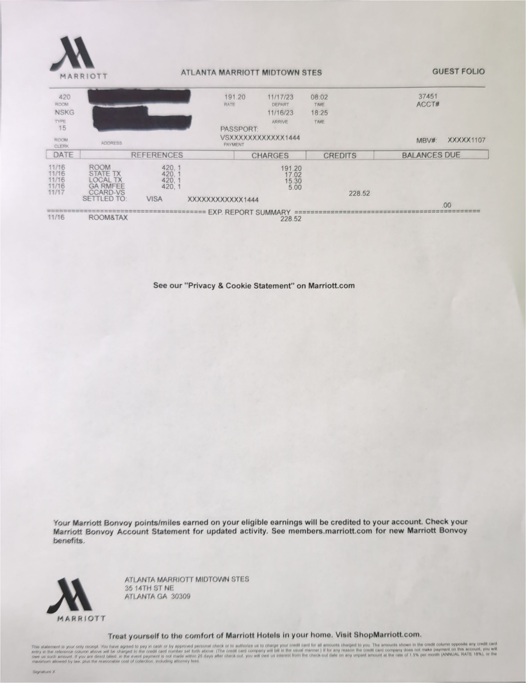

In [33]:
IPython.display.display(
    image.resize(
        (int(.3 * page.image.width), int(.3 * page.image.height))
    )
)

In [34]:
page.detected_barcodes

[]

In [35]:
page.visual_elements

[]

### Python Helper Function

For extracting components from a page: blocks, paragraphs, lines, tokens, symbols

A simple function to extract a given component (block, paragraph, line, token, symbol) from a page:

In [36]:
def extractor(component):
    
    components = []
    
    for part in component:
        components.append(
            "".join(
                [
                    response.document.text[segment.start_index:segment.end_index] for segment in part.layout.text_anchor.text_segments
                ]
            )
        )
    
    return components

A simple function to annotate a given component (block, paragraph, line, token, symbol) from a page on the page image:

In [37]:
def annotator(image, component, line_size = 5):
    
    annotated_image = image.copy()
    draw = PIL.ImageDraw.Draw(annotated_image)
    
    for part in component:
        if len(part.layout.bounding_poly.normalized_vertices) > 2:
            draw.polygon(
                [(v.x * page.image.width, v.y * page.image.height) for v in part.layout.bounding_poly.normalized_vertices],
                outline = 'green',
                width = line_size
            )
    
    IPython.display.display(annotated_image)
    
    return

### Pages:Blocks

- [documentai.Document.Page.Block](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document.Page.Block)

In [38]:
blocks = extractor(page.blocks)

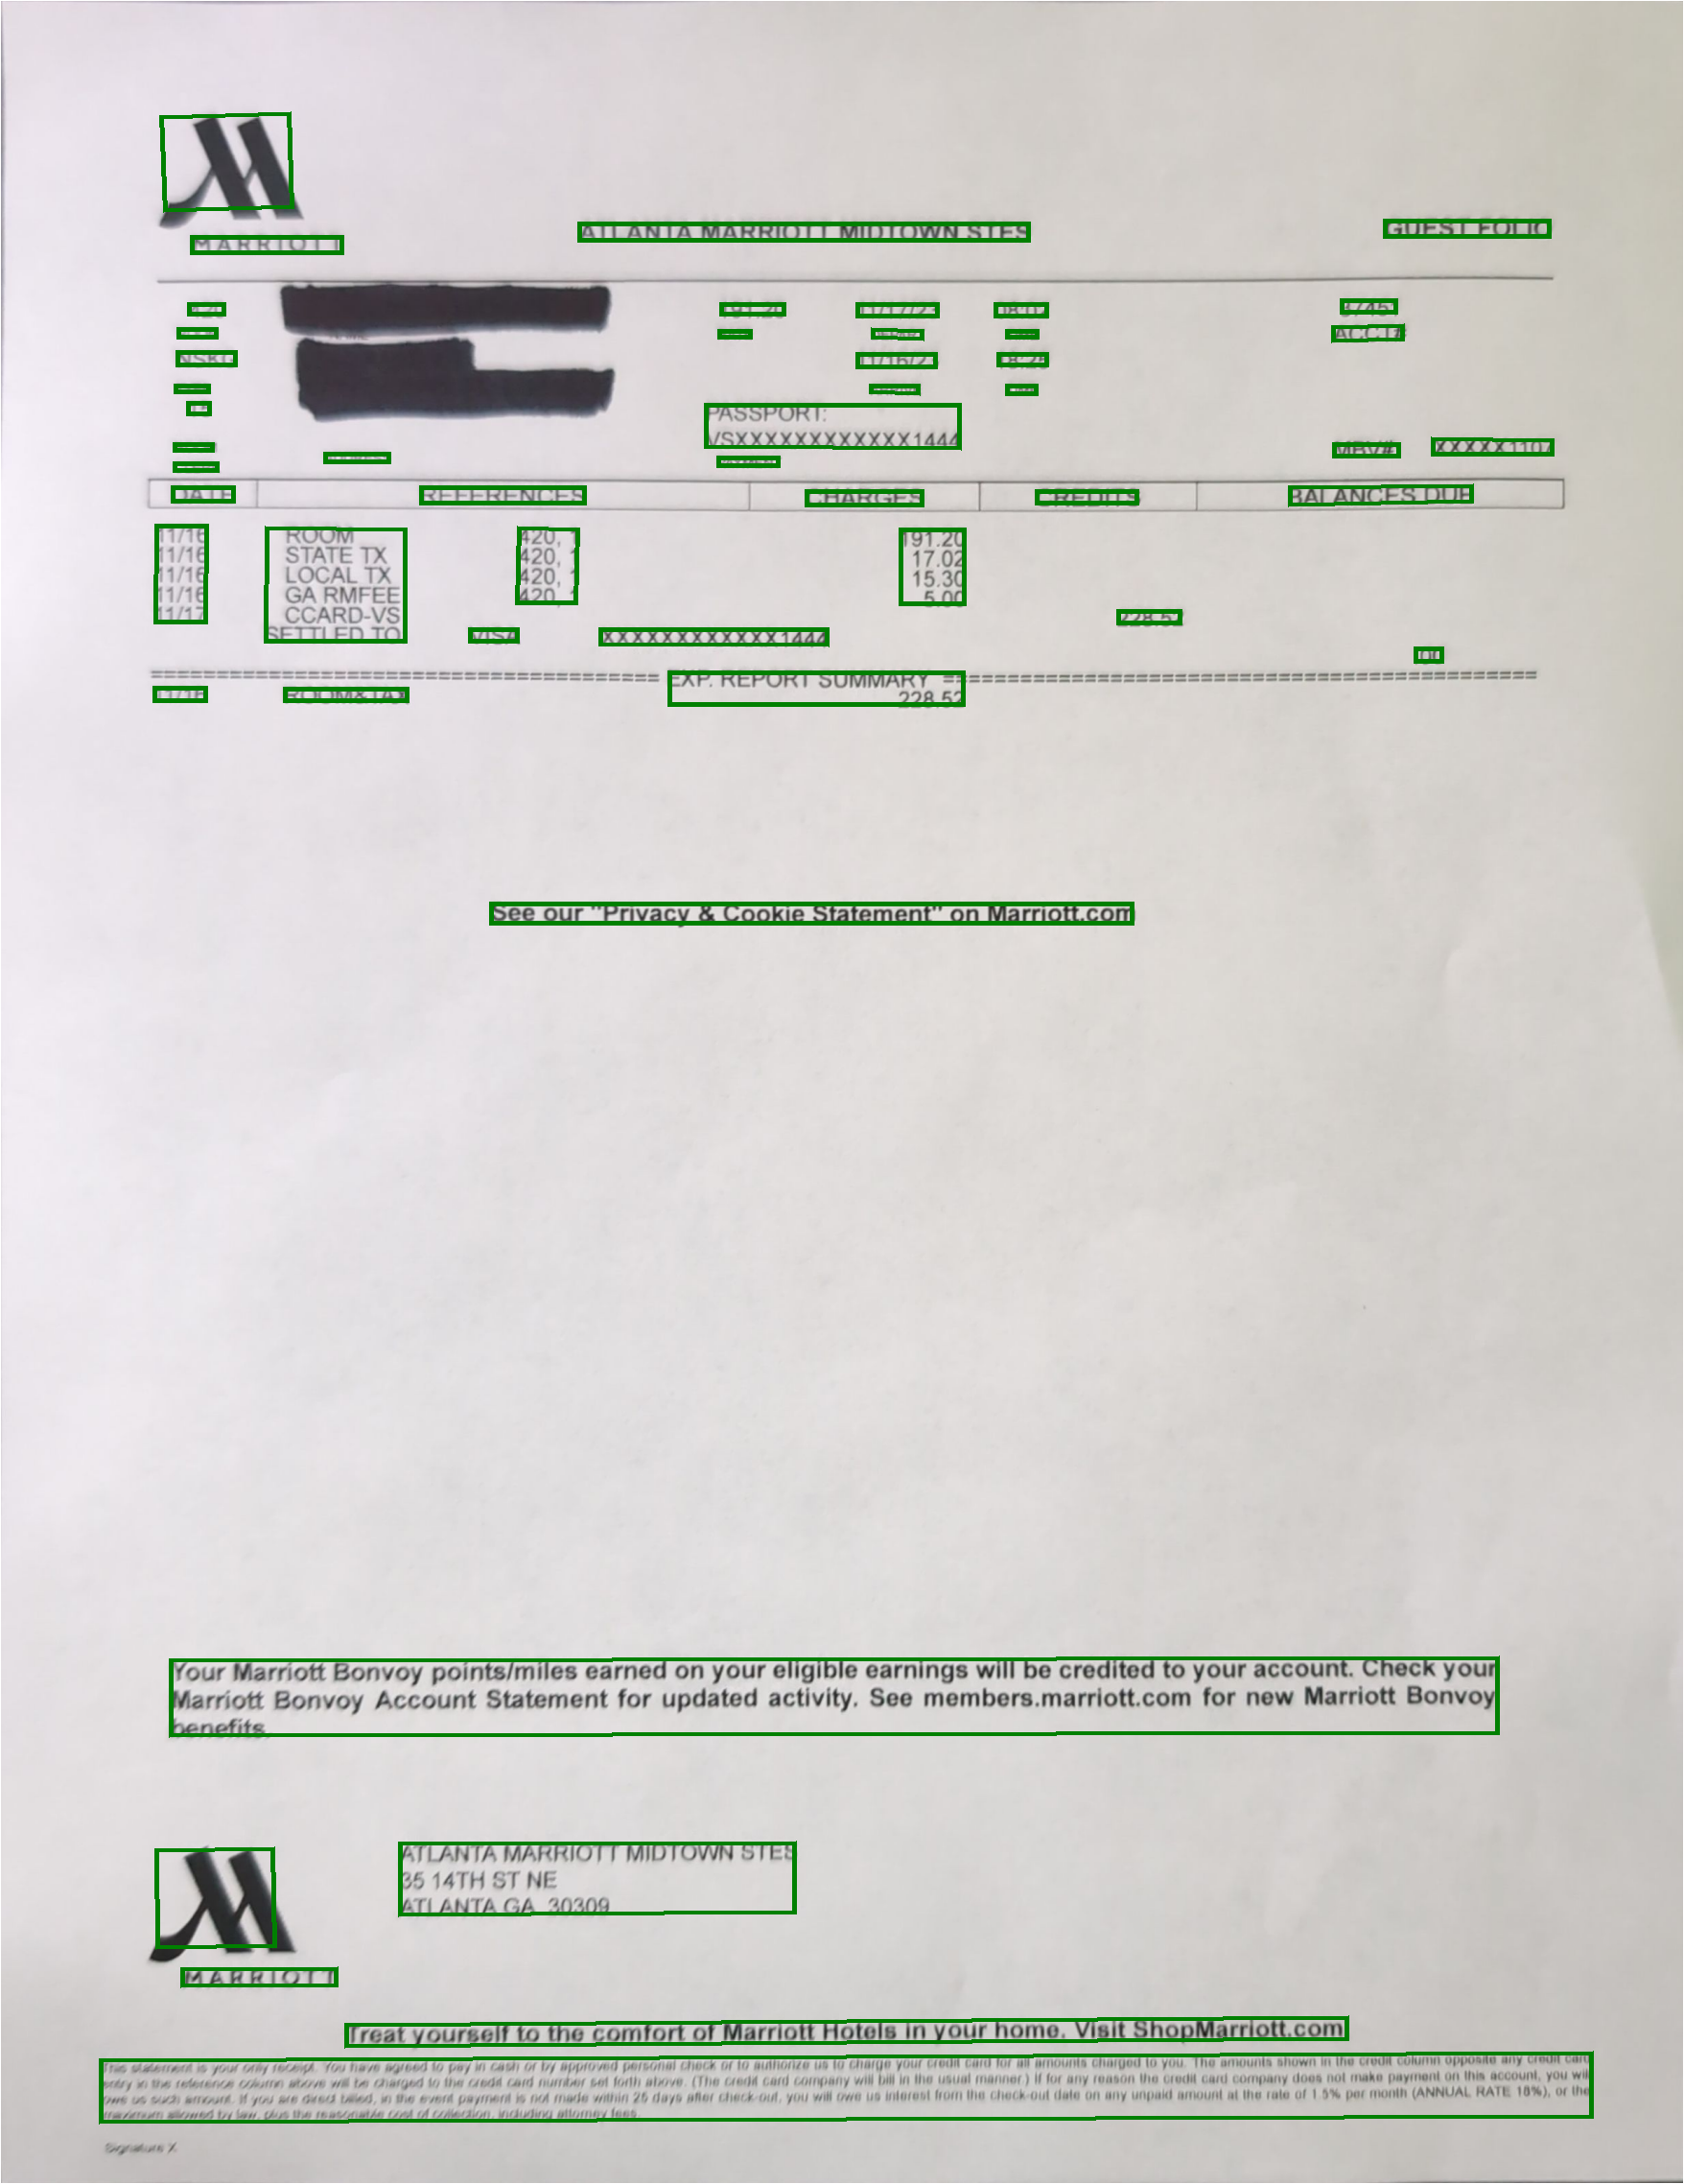

In [39]:
annotator(image, page.blocks)

In [40]:
for p, part in enumerate(blocks):
    print(f'{p} -------------------------------------------------------------------:\n{part}')

0 -------------------------------------------------------------------:
M

1 -------------------------------------------------------------------:
ATLANTA MARRIOTT MIDTOWN STES

2 -------------------------------------------------------------------:
GUEST FOLIO

3 -------------------------------------------------------------------:
MARRIOTT

4 -------------------------------------------------------------------:
420

5 -------------------------------------------------------------------:
191.20

6 -------------------------------------------------------------------:
11/17/23

7 -------------------------------------------------------------------:
08:02

8 -------------------------------------------------------------------:
37451

9 -------------------------------------------------------------------:
ROOM

10 -------------------------------------------------------------------:
RATE

11 -------------------------------------------------------------------:
DEPART

12 -----------------------------

### Pages:Paragraphs

- [documentai.Document.Page.Paragraph](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document.Page.Paragraph)

In [41]:
paragraphs = extractor(page.paragraphs)

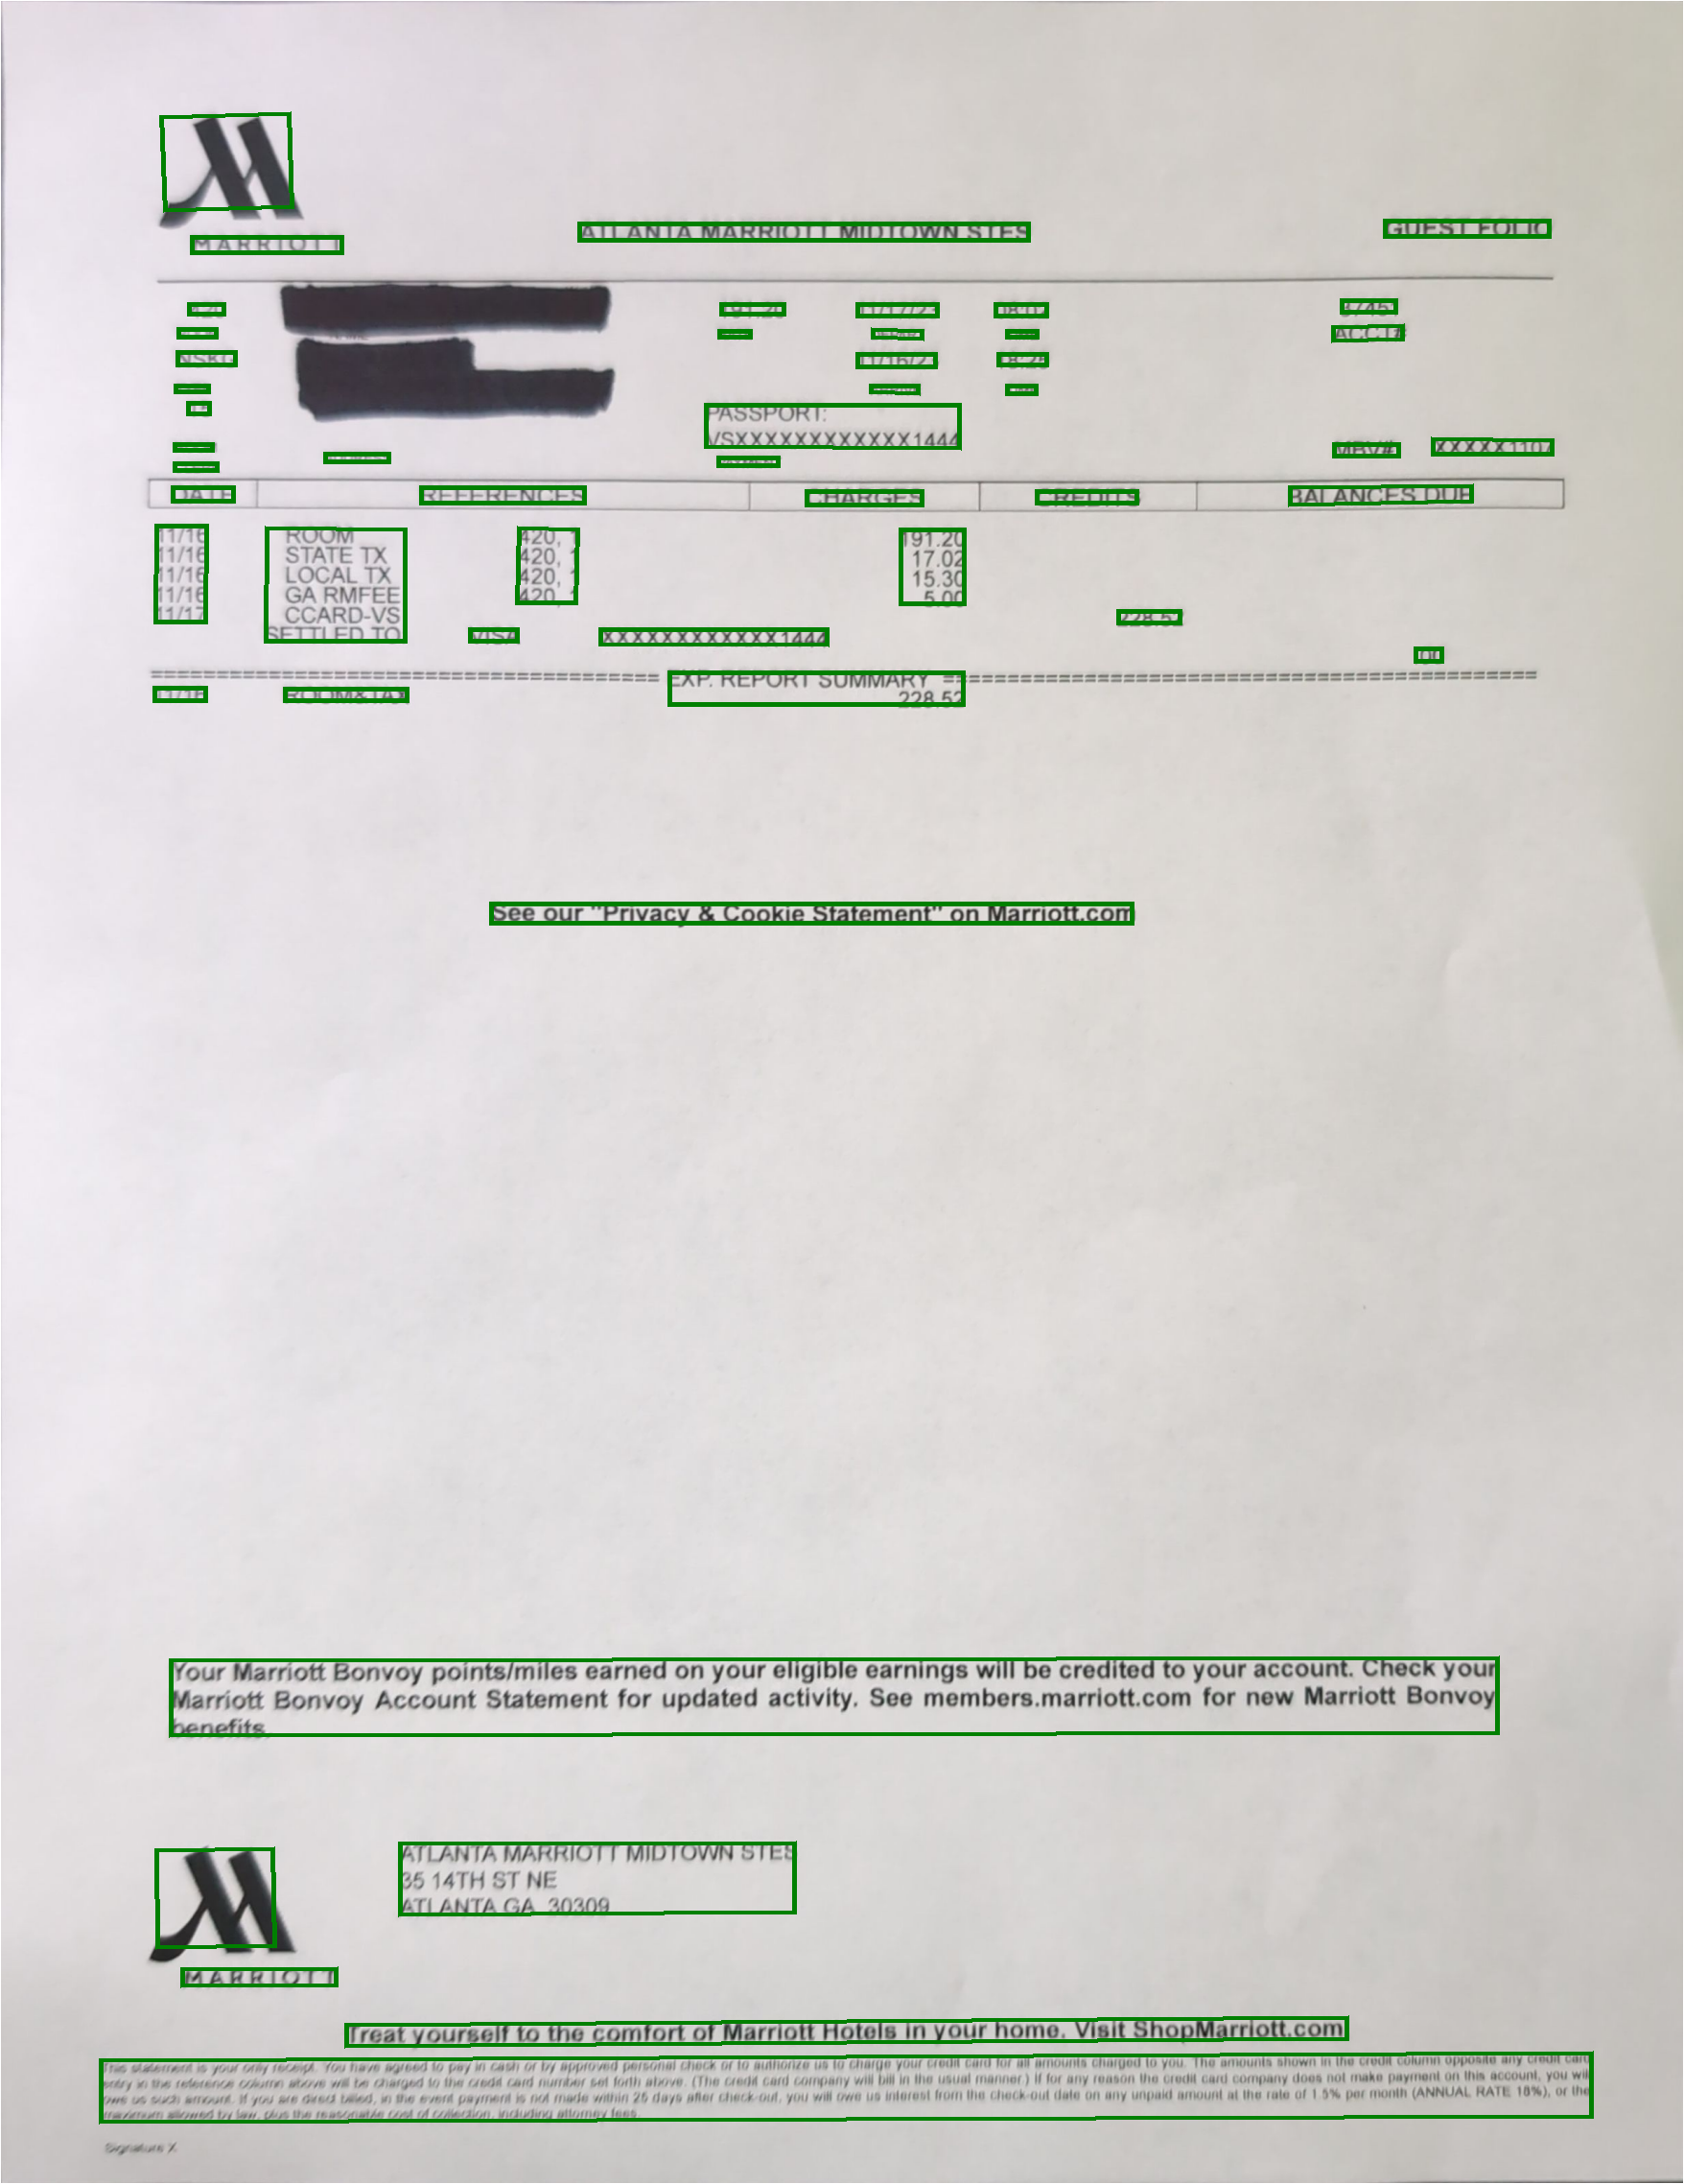

In [42]:
annotator(image, page.paragraphs)

In [43]:
for p, part in enumerate(paragraphs):
    print(f'{p} -------------------------------------------------------------------:\n{part}')

0 -------------------------------------------------------------------:
M

1 -------------------------------------------------------------------:
ATLANTA MARRIOTT MIDTOWN STES

2 -------------------------------------------------------------------:
GUEST FOLIO

3 -------------------------------------------------------------------:
MARRIOTT

4 -------------------------------------------------------------------:
420

5 -------------------------------------------------------------------:
191.20

6 -------------------------------------------------------------------:
11/17/23

7 -------------------------------------------------------------------:
08:02

8 -------------------------------------------------------------------:
37451

9 -------------------------------------------------------------------:
ROOM

10 -------------------------------------------------------------------:
RATE

11 -------------------------------------------------------------------:
DEPART

12 -----------------------------

### Pages:Lines

- [documentai.Document.Page.Line](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document.Page.Line)

In [44]:
lines = extractor(page.lines)

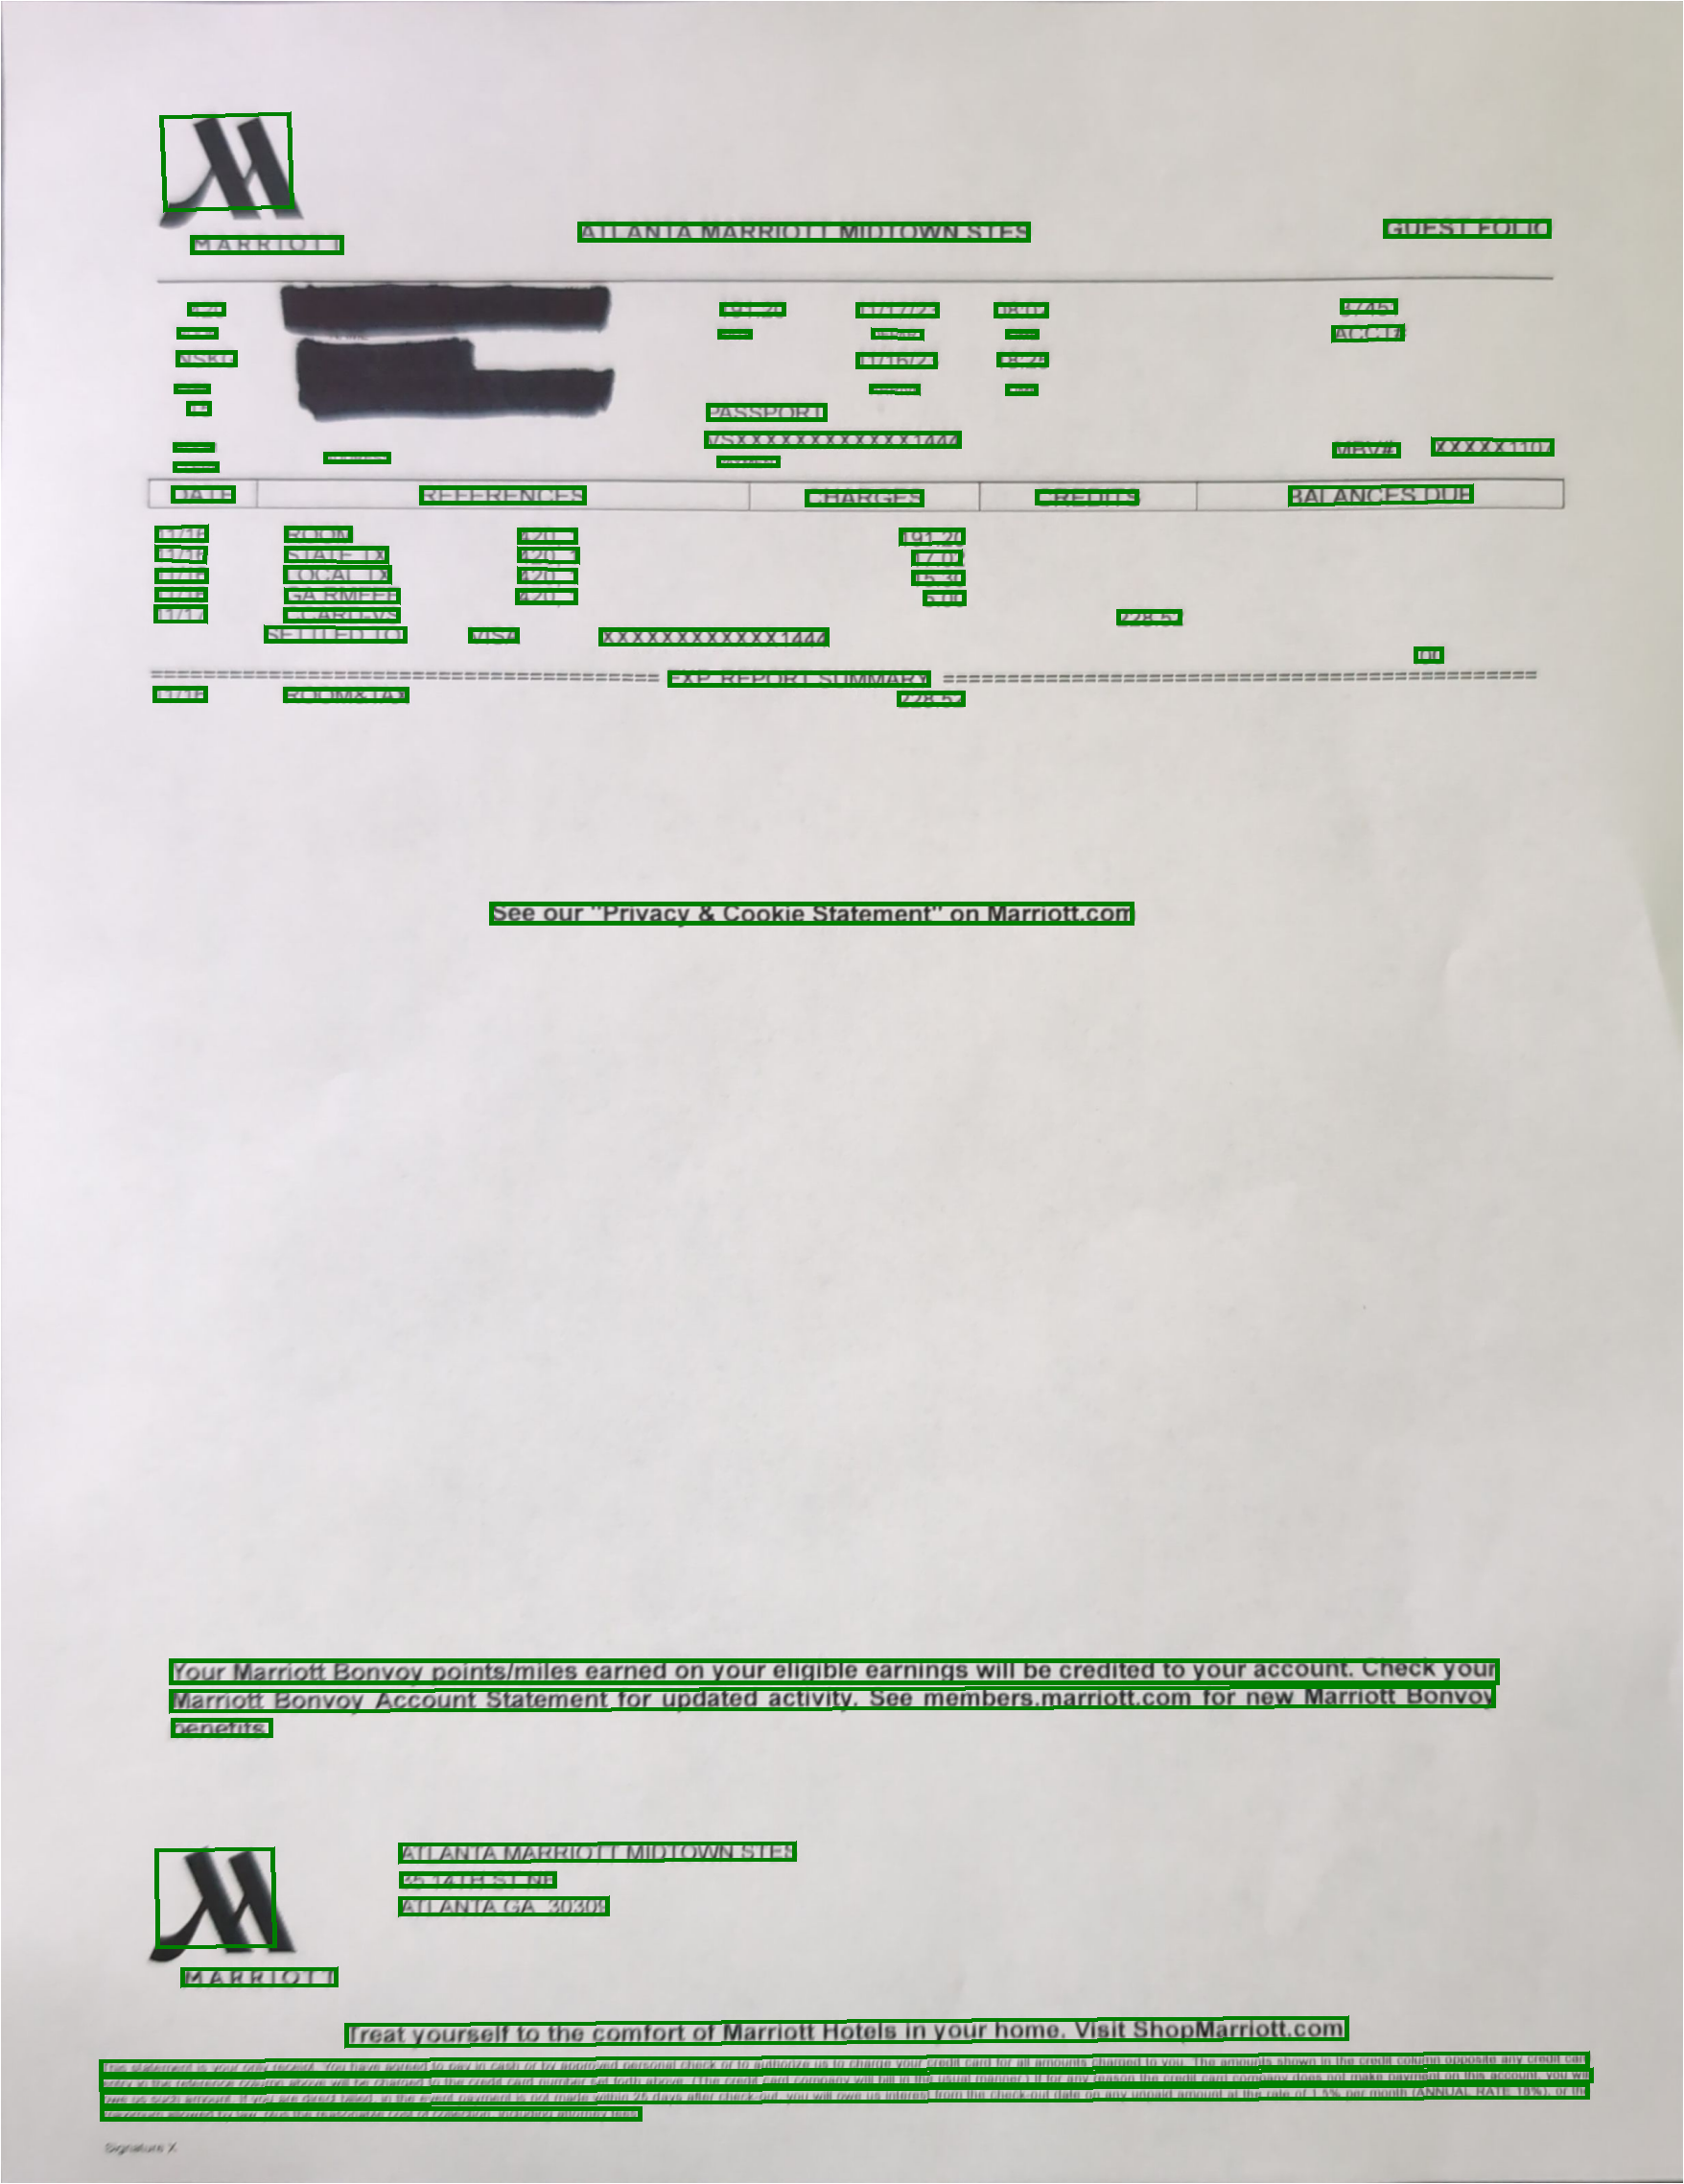

In [45]:
annotator(image, page.lines)

In [46]:
for p, part in enumerate(lines):
    print(f'{p} --------------------------------------: {part}')

0 --------------------------------------: M

1 --------------------------------------: ATLANTA MARRIOTT MIDTOWN STES

2 --------------------------------------: GUEST FOLIO

3 --------------------------------------: MARRIOTT

4 --------------------------------------: 420

5 --------------------------------------: 191.20

6 --------------------------------------: 11/17/23

7 --------------------------------------: 08:02

8 --------------------------------------: 37451

9 --------------------------------------: ROOM

10 --------------------------------------: RATE

11 --------------------------------------: DEPART

12 --------------------------------------: TIME

13 --------------------------------------: ACCT#

14 --------------------------------------: NSKG

15 --------------------------------------: 11/16/23

16 --------------------------------------: 18:25

17 --------------------------------------: TYPE

18 --------------------------------------: ARRIVE

19 --------------------------

### Pages:Tokens

- [documentai.Document.Page.Token](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document.Page.Token)

In [47]:
tokens = extractor(page.tokens)

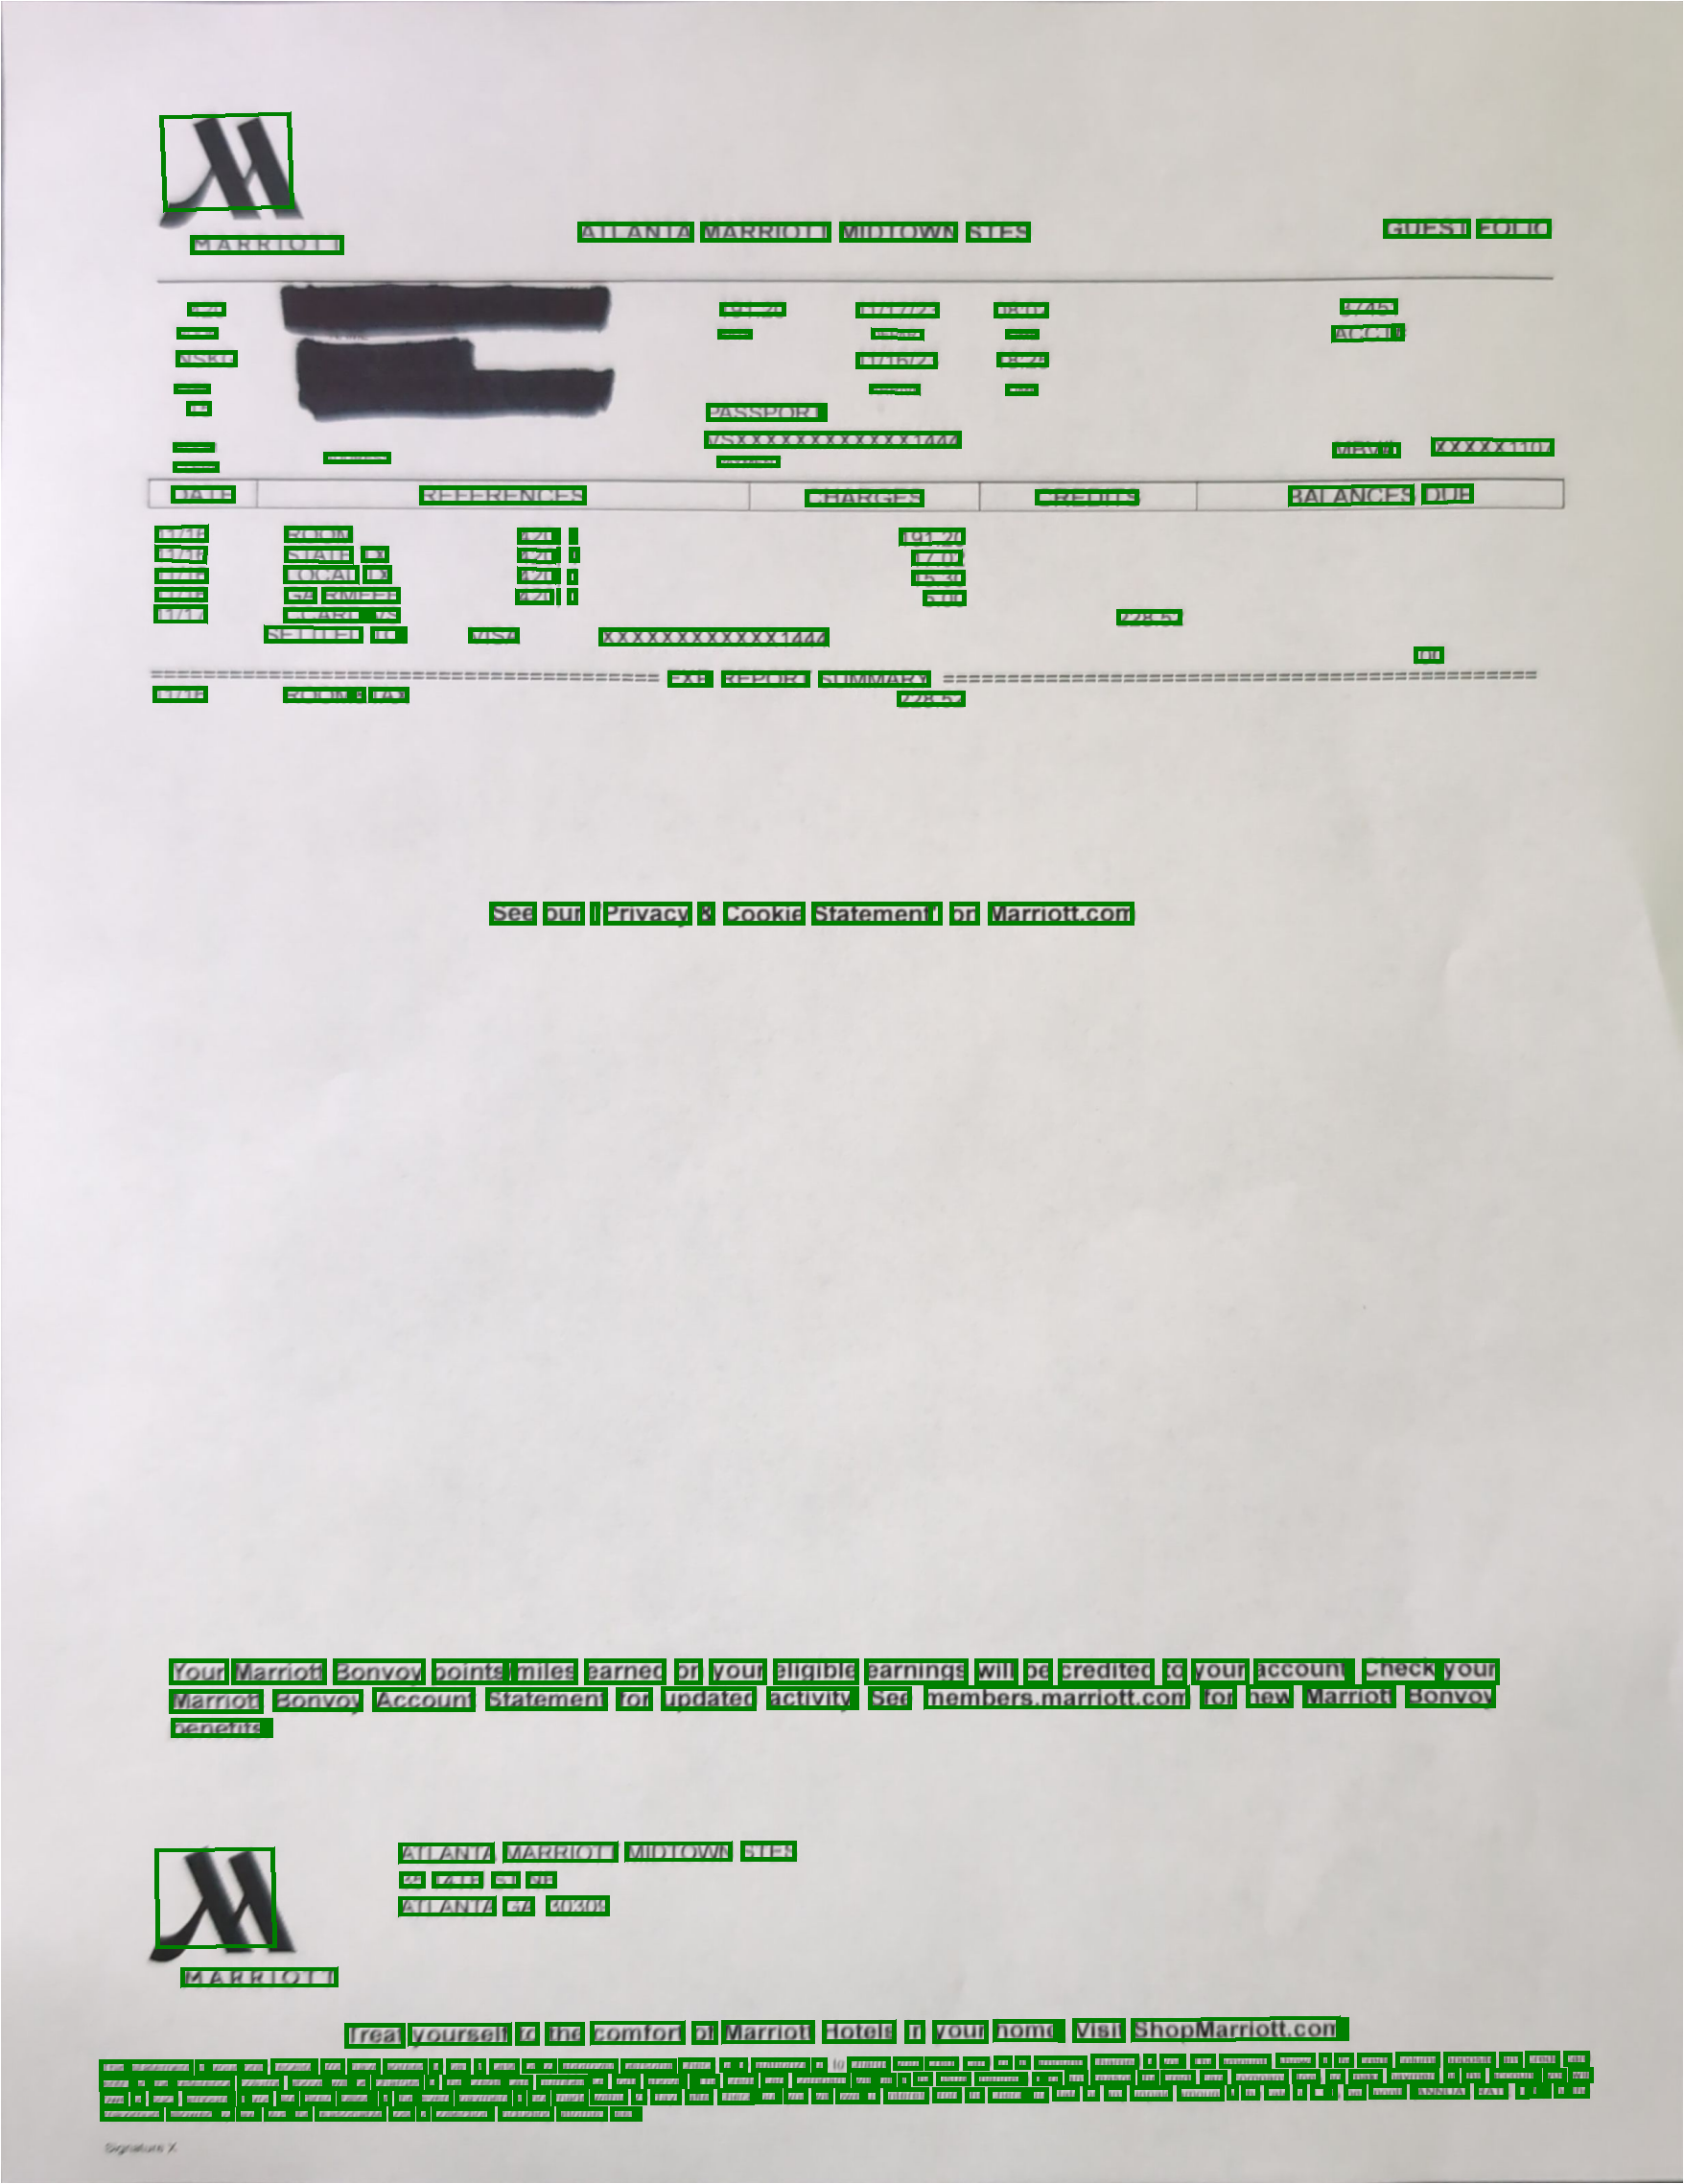

In [48]:
annotator(image, page.tokens)

In [49]:
for p, part in enumerate(tokens):
    if len(tokens) > 100:
        if p>50 and p<len(tokens)-50:
            continue
    print(f'{p} --------------------------------------: {part}')

0 --------------------------------------: M

1 --------------------------------------: ATLANTA 
2 --------------------------------------: MARRIOTT 
3 --------------------------------------: MIDTOWN 
4 --------------------------------------: STES

5 --------------------------------------: GUEST 
6 --------------------------------------: FOLIO

7 --------------------------------------: MARRIOTT

8 --------------------------------------: 420

9 --------------------------------------: 191.20

10 --------------------------------------: 11/17/23

11 --------------------------------------: 08:02

12 --------------------------------------: 37451

13 --------------------------------------: ROOM

14 --------------------------------------: RATE

15 --------------------------------------: DEPART

16 --------------------------------------: TIME

17 --------------------------------------: ACCT
18 --------------------------------------: #

19 --------------------------------------: NSKG

20 ---------

### Entities

Entities are extracted key:value pairs from the overall document.  Each parser has specific entities it is trained to detect and return.  In this case, the General Form Parser, there are several field it is trained to detect and label.

In [51]:
len(response.document.entities)

10

In [54]:
response.document.entities[0]

text_anchor {
  text_segments {
    start_index: 823
    end_index: 831
  }
  content: "MARRIOTT"
}
type_: "supplier_name"
mention_text: "MARRIOTT"
confidence: 0.5202292203903198
page_anchor {
  page_refs {
    bounding_poly {
      normalized_vertices {
        x: 0.10706150531768799
        y: 0.9007465839385986
      }
      normalized_vertices {
        x: 0.20102505385875702
        y: 0.9007465839385986
      }
      normalized_vertices {
        x: 0.20102505385875702
        y: 0.9099692702293396
      }
      normalized_vertices {
        x: 0.10706150531768799
        y: 0.9099692702293396
      }
    }
  }
}
id: "0"

In [73]:
for e, entity in enumerate(response.document.entities):
    a = entity.type_
    if entity.normalized_value:
        b = entity.normalized_value
    else:
        b = entity.mention_text
    
    print(f"--------- Entity {e} -------------:\n{a}\n{b}")
    
    if entity.properties:
        print(f"\n--------- Entity {e} Properties ---------:")
        for prop in entity.properties:
            if prop.normalized_value:
                c = prop.normalized_value
            else:
                c = prop.mention_text
            print(f'{prop.type_} = {c}')

--------- Entity 0 -------------:
supplier_name
MARRIOTT
--------- Entity 1 -------------:
invoice_type
text: "hotel_statement"

--------- Entity 2 -------------:
supplier_address
text: "35 14th St NE Atlanta, GA 30309 USA"
address_value {
  region_code: "US"
  language_code: "en-US"
  postal_code: "30309"
  administrative_area: "Georgia"
  locality: "Atlanta"
  address_lines: "35 14th St NE"
}

--------- Entity 3 -------------:
supplier_website
ShopMarriott.com.
--------- Entity 4 -------------:
line_item
191.20

--------- Entity 4 Properties ---------:
line_item/unit_price = text: "191.2"

--------- Entity 5 -------------:
line_item
ROOM
STATE TX 191.20 17.02

--------- Entity 5 Properties ---------:
line_item/description = ROOM
STATE TX
line_item/amount = text: "191.2"

--------- Entity 6 -------------:
line_item
LOCAL TX 15.30

--------- Entity 6 Properties ---------:
line_item/description = LOCAL TX
line_item/amount = text: "15.3"

--------- Entity 7 -------------:
line_item
GA RM